<a href="https://colab.research.google.com/github/figueiredoelizeu/Projeto_Transfer_Learning_Python/blob/main/ReconhecimentoFacialdoZero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reconhecimento Facial do Zero**
Esse sistema de detecção e reconhecimento facial utiliza o framework TensorFlow.

In [1]:
# Instalação do OpenCV
!pip install opencv-python

# Instalação do TensorFlow e Keras ou atualização

!pip install tensorflow
!pip install keras

In [2]:
# Faz o upload do arquivo ZIP do seu computador
from google.colab import files
uploaded = files.upload()

# Descompacta o arquivo ZIP
import zipfile
import io

# Assume que o nome do seu arquivo zip é 'dataset.zip'
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
  zip_ref.extractall()
  zip_ref.close()

Saving dataset.zip to dataset.zip
User uploaded file "dataset.zip" with length 1646673 bytes


In [20]:
import os
import cv2
import numpy as np
from PIL import Image

# Caminho para o diretório de dados
data_path = 'dataset'

# Classificador de face do OpenCV para detecção
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

if face_cascade.empty():
    raise IOError("O arquivo haarcascade não foi carregado corretamente. Verifique o caminho.")

# Listas para armazenar as faces e os IDs
faces = []
ids = []
labels = {}
label_id = 0

# Percorre as pastas no diretório de dados
for dirname in os.listdir(data_path):
    subject_path = os.path.join(data_path, dirname)
    if not os.path.isdir(subject_path):
        continue

    # Atribui um ID a cada nome
    if dirname not in labels:
        labels[dirname] = label_id
        label_id += 1

    # Percorre as imagens em cada pasta
    for filename in os.listdir(subject_path):
        image_path = os.path.join(subject_path, filename)

        # Converte a imagem para escala de cinza
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detecta faces na imagem
        detected_faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5)

        # Para cada face detectada, adiciona à lista
        for (x, y, w, h) in detected_faces:
            faces.append(gray_image[y:y+h, x:x+w])
            ids.append(labels[dirname])

# Treina o modelo de reconhecimento (usando LBPH)
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(faces, np.array(ids))

# Salva o modelo treinado para uso posterior
recognizer.save('trained_recognizer.yml')
np.save('labels_map.npy', labels)

print("Modelo de reconhecimento treinado e salvo com sucesso!")

Modelo de reconhecimento treinado e salvo com sucesso!


Rodando o sistema:

Saving Imagem_Elizeu.jpg to Imagem_Elizeu (1).jpg


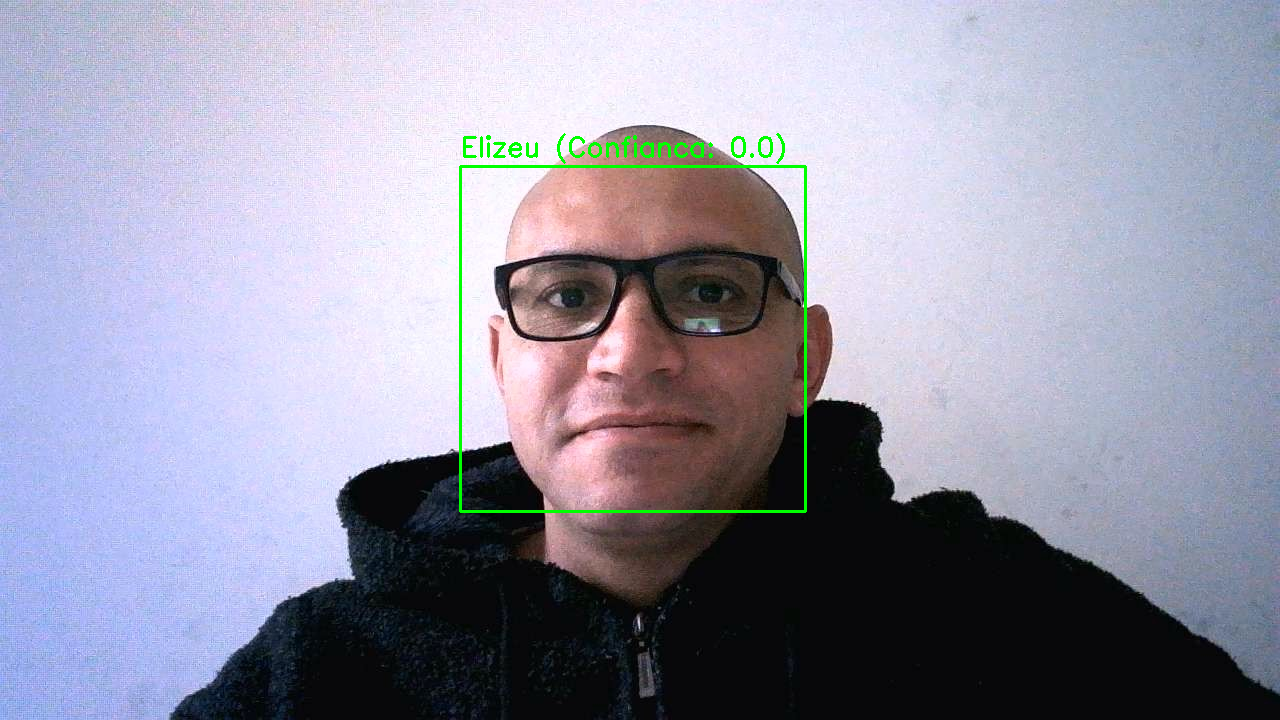

In [22]:
# Carrega o modelo treinado e o mapa de rótulos
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('trained_recognizer.yml')

# Carrega o mapa de rótulos e inverte para fácil acesso
labels = np.load('labels_map.npy', allow_pickle=True).item()
labels_inverse = {v: k for k, v in labels.items()}

# Faz o upload da imagem de teste
uploaded_test_image = files.upload()
test_image_filename = list(uploaded_test_image.keys())[0]

# Carrega a imagem de teste
test_image = cv2.imread(test_image_filename)
gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Detecta as faces na imagem de teste
detected_faces = face_cascade.detectMultiScale(gray_test_image, scaleFactor=1.3, minNeighbors=5)

# Percorre as faces detectadas
for (x, y, w, h) in detected_faces:
    # Reconhece a face
    label_id_pred, confidence = recognizer.predict(gray_test_image[y:y+h, x:x+w])

    # Desenha a caixa delimitadora (bounding box)
    cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Exibe o nome se a confiança for alta (ajuste o valor se necessário)
    if confidence < 100:  # Um valor menor de confiança significa melhor correspondência
        label = labels_inverse[label_id_pred]
        text = f"{label} (Confianca: {round(confidence, 2)})"
    else:
        text = "Desconhecido"

    # Desenha o texto
    cv2.putText(test_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Exibe a imagem final
from google.colab.patches import cv2_imshow
cv2_imshow(test_image)